In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**<h2> MADS: Milestone II (Team 10) - Preprocessing, Features Engineering, and Supervised Learning</h2>**
<h3> Topic: Machine learning on duty: solving consumer complaints and improving satisfaction!</h3>
<h4> Authors: Chih-Han Yeh (yehch), Yi-Hsin Chien (yihsinc), Weiming Chen ( weimingc) </h4>
<h4> Mentor: Alexis Castellanos</h4>

**<h3>Project Overview</h3></br>**
In response to the escalating volume of consumer complaints and the complexities involved in addressing them promptly, our dedicated team is committed to leveraging data-driven strategies to enhance our comprehension of these complaints. Our overarching objective is to develop efficient techniques for managing and resolving complaints by predicting which ones are likely to be disputed by consumers and unveiling concealed patterns or clusters within the narrative of these complaints.

**<h3>Environment Setting</h3></br>**
Importing libraries we need for our project.

In [34]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 17.6 MB/s eta 0:00:00


In [35]:
# Built-in libraries
import re
import string
import warnings

# Third-party libraries for data handling and processing
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm import tqdm

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import KeyedVectors

# Pre-processing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, MaxAbsScaler
from imblearn.over_sampling import SMOTE

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Machine Learning Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Deep Learning Libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, LSTM
from keras.callbacks import EarlyStopping

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt


# Miscellaneous
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
tqdm.pandas()
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
# files
file_path_01 = '/content/drive//MyDrive/milestone II/complaints.csv'

file_path_03 = '/content/drive/MyDrive/milestone II/GoogleNews-vectors-negative300.bin.gz'

# import DATA
DATA = pd.read_csv(file_path_01)

print(DATA.shape)

(4091495, 18)


# **CFBP Dataset**

**•	Where the datasets or API resource is located </br>**
Our dataset is drawn from the CFPB Consumer Complaint Database, encompassing complaint receipt dates, product types, issues, consumer narratives, and various other attributes. We downloaded the dataset from the link: https://files.consumerfinance.gov/ccdb/complaints.csv.zip.

**•	What formats they returned/used</br>**
The format of our dataset is a CSV file.

**•	What were the important variables contained in them</br>**
The important variables are Product, Sub-product, Issue, Sub-issue, Consumer complaint narrative, Company public response, Company, State, Zip code, Company response to Consumer, and Consumer disputed.

**•	How many records you used or retrieved (if using an API)</br>**
Our dataset contains 4,101,381 entries and is around 2.61 GB.

**•	What time periods they covered (if there is a time element)</br>**
The period of our dataset is from 2011-12-01 to 2023-09-22.

**•	What initial preprocessing was required to handle noisy or missing data</br>**
A strategic methodology is essential to address the intricacies of consumer complaints effectively. Firstly, a focused analysis of the "Credit reporting, credit repair services, or other personal consumer reports" category is imperative due to the high frequency of complaints within this segment. Specialized models and analysis pipelines for this category will enable us to extract detailed and specific insights. Before delving into Word Embedding and Feature Vectorization, it's paramount to maintain the integrity of our dataset. We must address columns with persistent missing data, such as "Tags," by removing or blaming them. Essential columns with incomplete data should be rectified using central tendency measures or interpolation. Following this, optimizing our feature set by eliminating redundant or irrelevant attributes, enhancing the model's precision, and reducing overfitting risks is vital. Word Embedding and Feature Vectorization, mainly deriving attributes from the "Consumer complaint narrative," is our subsequent focus. By extracting key insights such as sentiment scores, narrative lengths, and keyword frequencies, we add depth to our dataset. Translating categorical variables, like product types, into numerical formats will further streamline our data structure.

# **Feature Engineering**

**Step 1: Deep Dive into Credit Reporting Complaints and few Companies**



*   **Credit Reporting**

> From our exploratory data analysis (EDA), we discerned that the "Credit reporting, credit repair services, or other personal consumer reports" category constitutes the largest segment of our dataset. Delving further into the Sub-Product columns revealed a pronounced data imbalance. Specifically, credit reporting dominates the data, comprising approximately 54%. As a result, our team has decided to concentrate on credit reporting, ensuring that our insights are precise and pertinent rather than attempting to generalize our analysis across all sub-products. Please see the chart below for a detailed visualization.

Credit Reporting accounts for 54.0% of the dataset


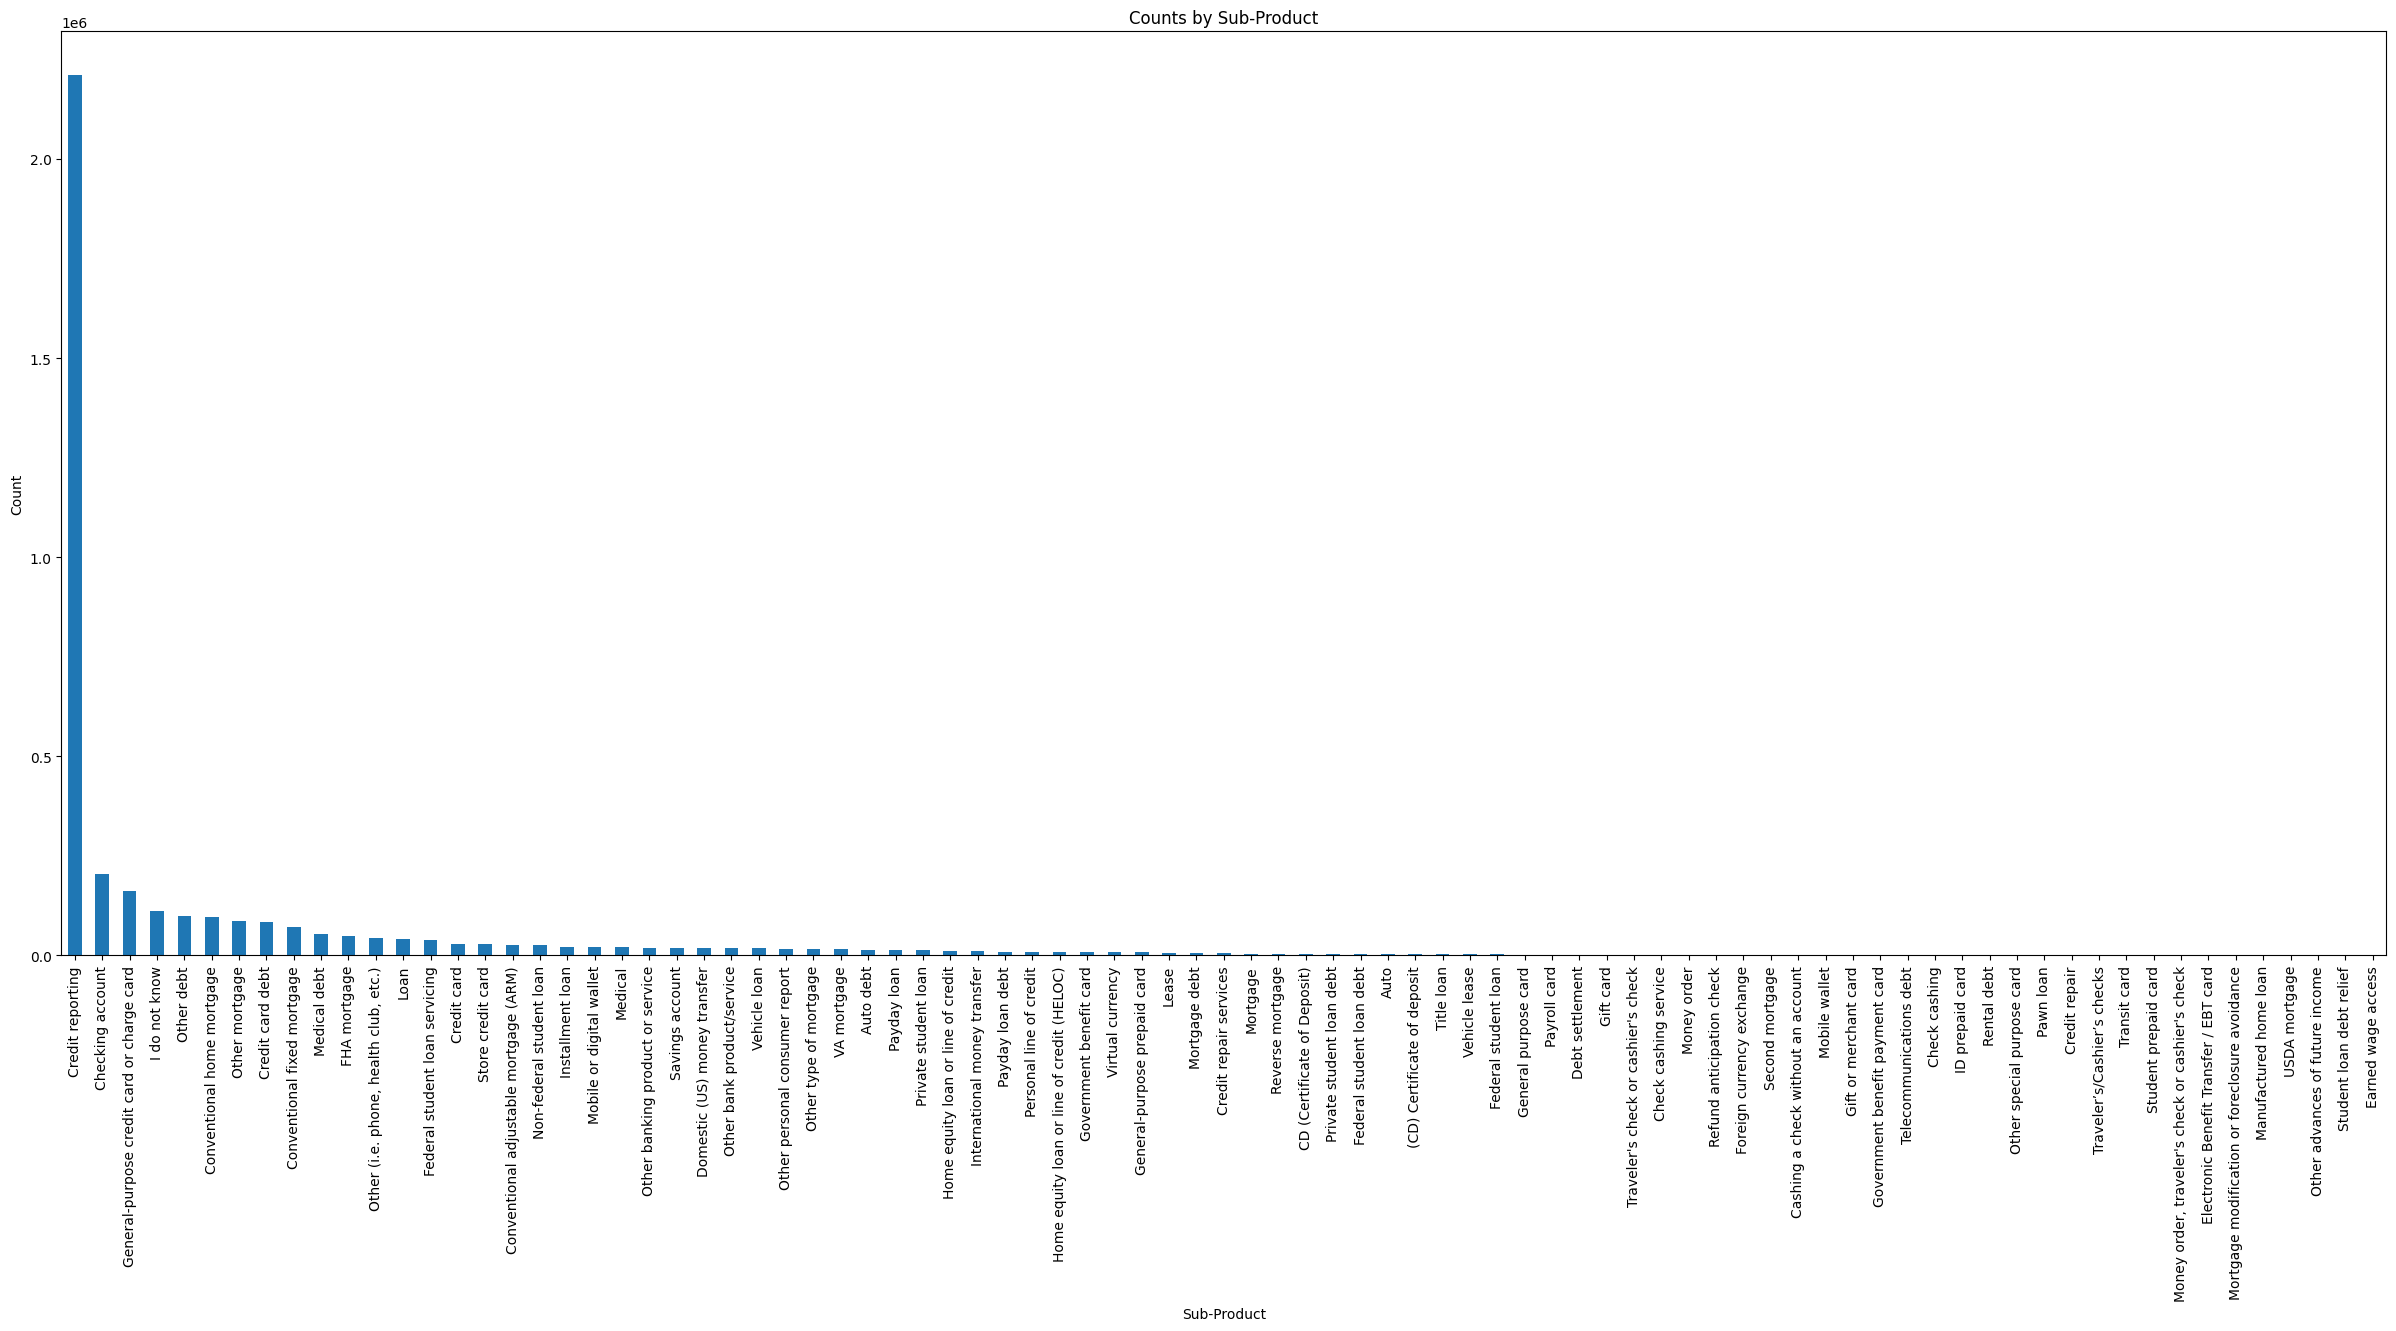

In [5]:
#calculate the share of the credit reporting of the whole dataset
credit = DATA[DATA['Sub-product'] == 'Credit reporting']
print('Credit Reporting accounts for {}% of the dataset'.format((round(len(credit)/len(DATA)*100,1))))
#visualize the imbalance situation
plt.figure(figsize=(30, 12))
DATA['Sub-product'].value_counts().plot(kind='bar')
plt.title('Counts by Sub-Product')
plt.xlabel('Sub-Product')
plt.ylabel('Count')
plt.show()

*   **Few Companies**


> From our exploratory data analysis (EDA), we observed that a handful of companies account for a significant portion of the complaint counts. Further examination of the company column showed a notable data disparity, with three particular companies making up roughly 88% of the complaints. Consequently, our team has narrowed our focus on these dominant companies to derive more accurate and contextually relevant insights. For a comprehensive visual representation, please refer to the chart below.

Three companies accounts for 88.0% of the credit dataset


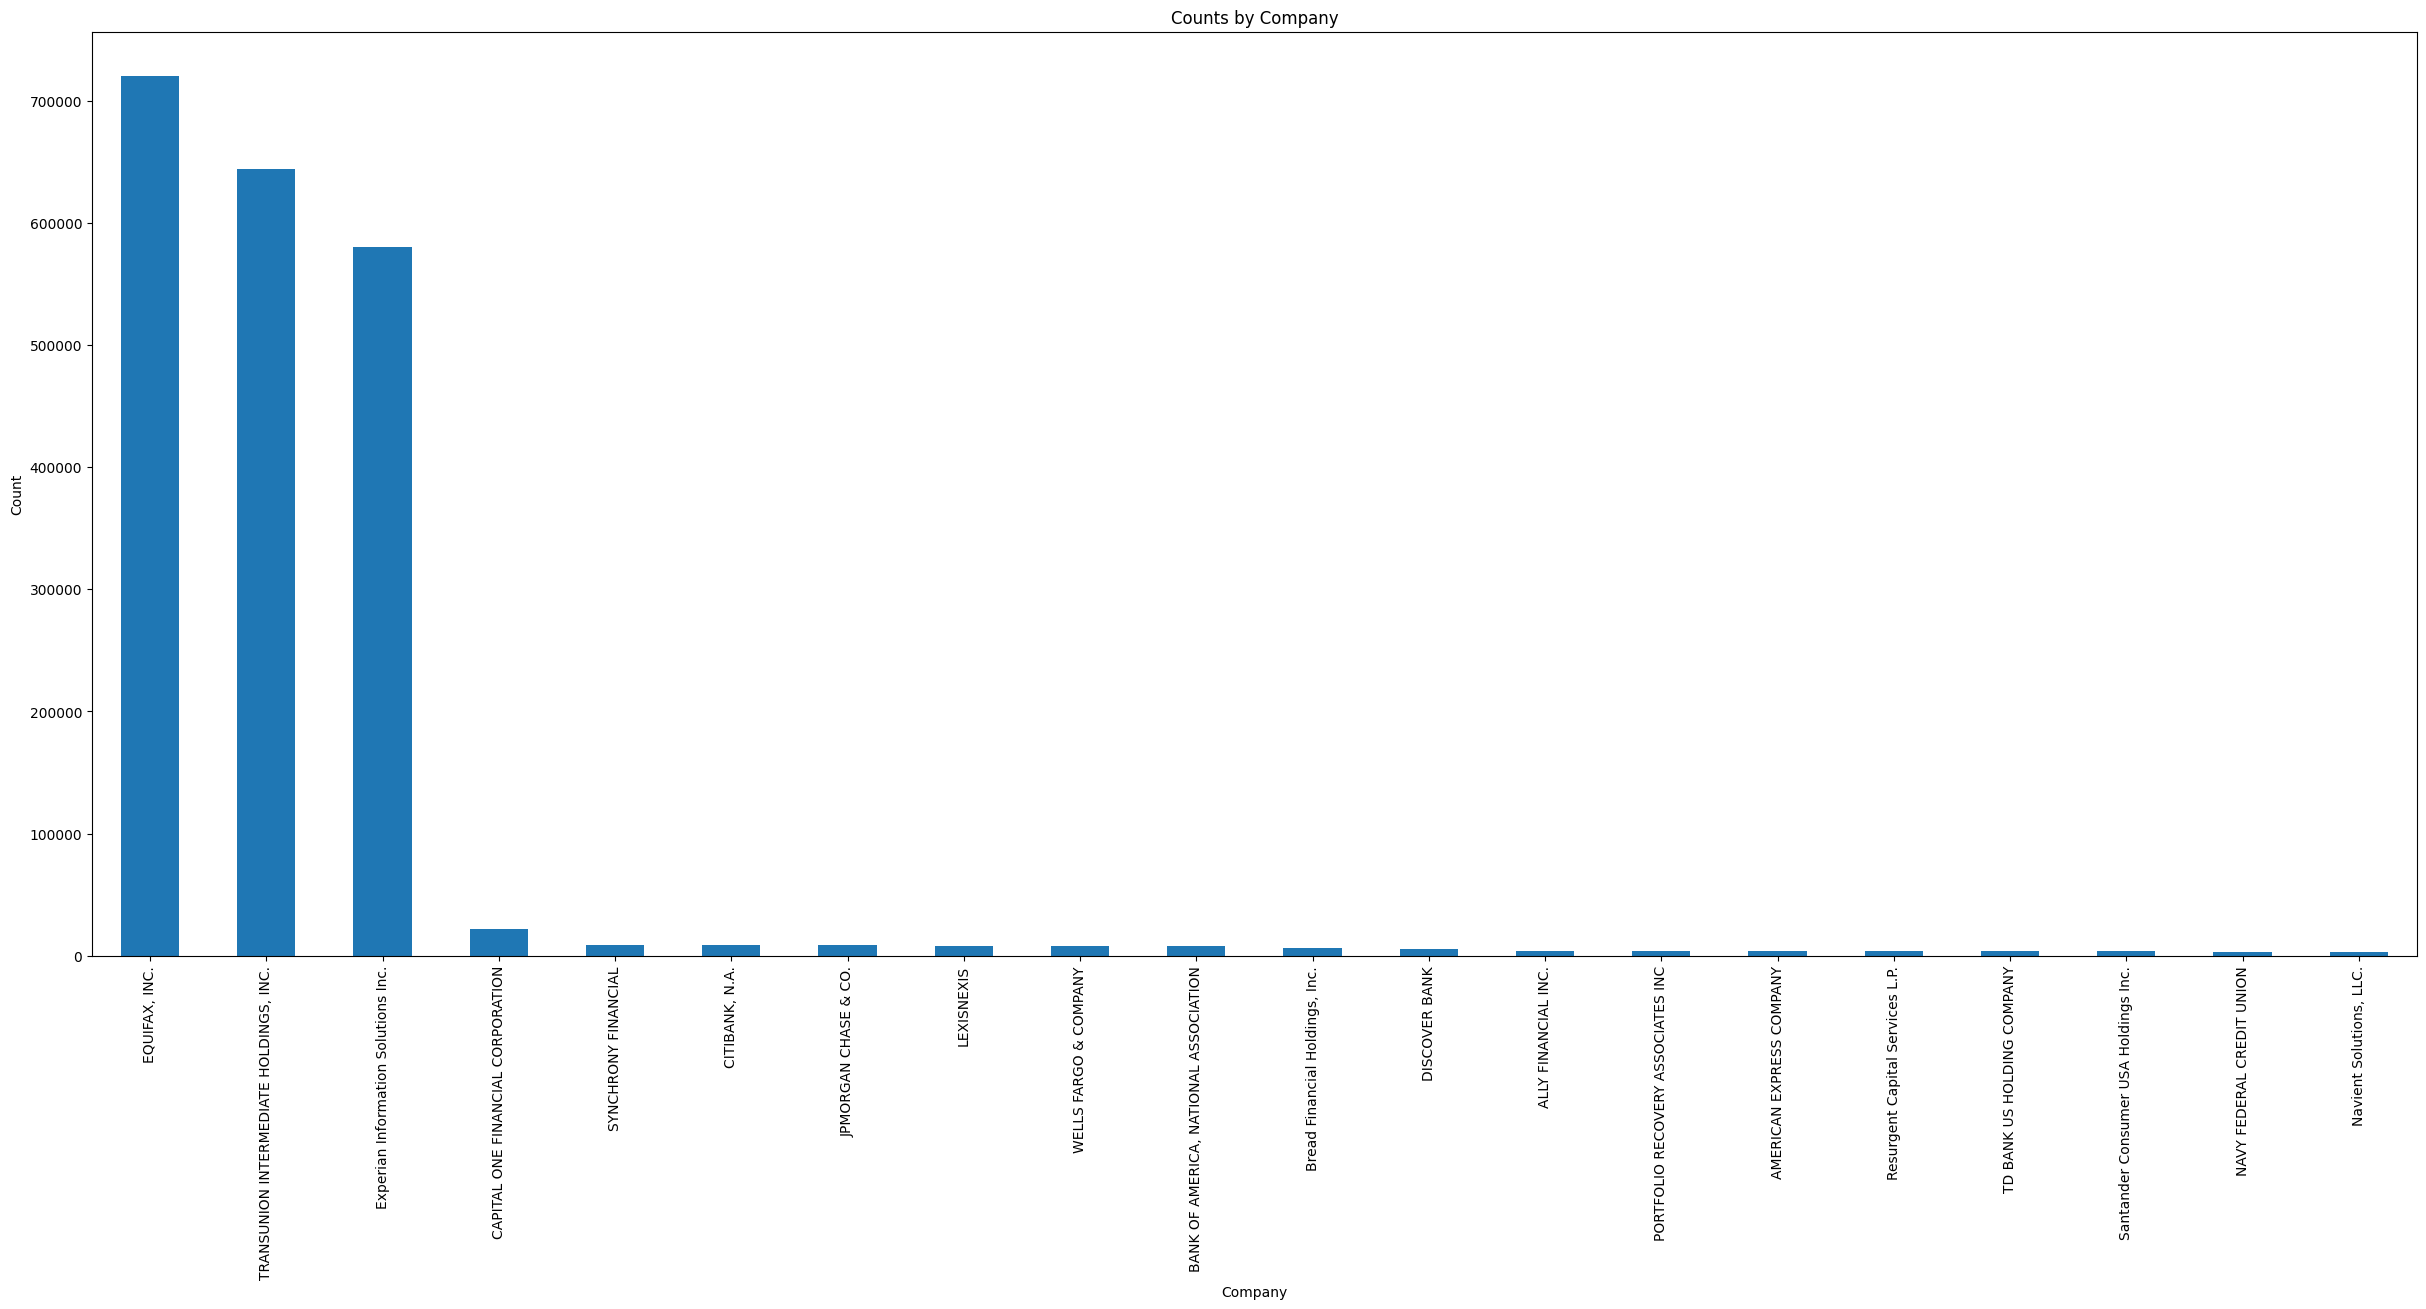

In [6]:
#calculate the shares of the top three companies of the whole credit reporting dataset
print('Three companies accounts for {}% of the credit dataset'.format((round(credit['Company'].value_counts().head(3).sum()/ len(credit)*100,1))))
#visualize the imbalance situation
plt.figure(figsize=(30, 12))
credit['Company'].value_counts().head(20).plot(kind='bar')
plt.title('Counts by Company')
plt.xlabel('Company')
plt.ylabel('Count')
plt.show()

**Summary: We narrowed down the dataset to focus on credit reporting and three companies: Equifax, Transunion, and Capital One. **


In [7]:
# Top 3 companies
company = list(credit['Company'].value_counts().head(3).index)
#credit reporting for top 3 companies
credit_company = credit[credit['Company'].isin(company)]
#refined dataframe is what portion of the original dataset
print('credit_company / original dataset: {}%'.format((round(len(credit_company)/len(DATA)*100,1))))

credit_company / original dataset: 47.5%


**Step 2: Feature Selection**


We've excluded the 'Complaint ID', 'Timely response?', 'Consumer consent provided?', 'Submitted via', and 'Tags' from our feature selection. Given that the 'Tags' feature is absent. Moreover, 'Complaint ID' is just a label not related to our focus. Lastly, 'Consumer consent provided?' and 'Submitted via' are removed due to no variance.

In [8]:
feature_selection = credit_company.drop(columns=['Tags', 'Complaint ID', 'Timely response?', 'Consumer consent provided?', 'Submitted via'])

In [9]:
feature_selection.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Date sent to company,Company response to consumer,Consumer disputed?
0,2023-08-24,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,Experian Information Solutions Inc.,NJ,07024,2023-08-24,In progress,NaN
3,2023-08-25,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",FL,33884,2023-08-25,Closed with non-monetary relief,NaN
6,2023-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,I submitted a letter to the XXXX Credit Bureau...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",FL,32221,2023-06-13,Closed with non-monetary relief,NaN


**Step 3: Handling Missing Data**


In [10]:
#As our focus is on the complaint narrative, we dropped rows with no narrative
clean = feature_selection[feature_selection['Consumer complaint narrative'].notnull()]
#notnull narrativ rows are what portion of the original dataset
print('clean / original dataset: {}%'.format((round(len(clean)/len(DATA)*100,1))))
print(clean.shape)
clean.head(3)

clean / original dataset: 15.8%
(646311, 13)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Date sent to company,Company response to consumer,Consumer disputed?
6,2023-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,I submitted a letter to the XXXX Credit Bureau...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",FL,32221,2023-06-13,Closed with non-monetary relief,NaN
37,2023-07-15,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,In accordance with the Fair Credit Reporting a...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,AL,35173,2023-07-15,Closed with non-monetary relief,NaN
40,2023-07-15,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Old information reappears or never goes away,XX/XX/XXXX ] [ XXXX XXXX XXXX ] [ XXXX XXXX XX...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MI,49022,2023-07-15,Closed with explanation,NaN


**Unexpected Findings**




> Initially, our intention was to train and test solely on the 'credit reporting' sub-product. However, given that none of the entries in this sub-product have a 'consumer disputed' label, we've chosen to designate this dataset as our test set. Instead, we'll leverage other sub-products with 'disputed' data to predict the 'disputed' labels for the 'credit reporting' sub-product entries. Consequently, this curated dataset has transitioned to serve as our test set. Please see the following results.



In [13]:
#Here this slice of dataset is filtered by whether the narratives is null or not: clean dataframe
#As we know from the EDA, the consumer-disputed Consumer features are missing after 2018. We divided the dataset into two parts: one with Consumer disputes and one without.
consumer_notnull = clean[clean['Consumer disputed?'].notnull()]
consumer_null = clean[clean['Consumer disputed?'].isnull()]
#show the lengths of each
print('Consumer disputed counts for credit reporting: {}'.format(len(consumer_notnull)))
print('Null Consumer disputed counts for credit reporting: {}'.format(len(consumer_null)))
#Credit reporting does not have consumer disputed data
print('The period of this chunk of the dataset was from {} to {}'.format(clean['Date received'].min(), clean['Date received'].max()))

Consumer disputed counts for credit reporting: 0
Null Consumer disputed counts for credit reporting: 646311
The time period of this chunk of dataset was from 2017-04-24 to 2023-09-09




>As we re-examine the filtered dataset by credit reporting and the top three companies, all entries did not have the consumer disputed data.



In [14]:
#re-examine the credit_company dataset to see the consumer disputed problem
print('Consumer disputed counts for credit reporting and the top three companies without filtering the narratives: {}'.format(len(credit_company[credit_company['Consumer disputed?'].notnull()])))
print('Null Consumer disputed counts for credit reporting and the top three companies without filtering the narratives:  {}'.format(len(credit_company[credit_company['Consumer disputed?'].isnull()])))

Consumer disputed counts for credit reporting and the top three companies without filtering the narratives: 0
Null Consumer disputed counts for credit reporting and the top three companies without filtering the narratives:  1944340


**Re-visit original dataset to examine not credit reporting sub-product**


In [15]:
#re-examine the DATA to see the consumer disputed problem beside credit-reporting
non_credit = DATA[DATA['Sub-product'] != 'Credit reporting' ]
print('Consumer disputed counts for sub-product other than credit reporting: {}'.format(len(non_credit)))
non_credit.head(3)

Consumer disputed counts for sub-product other than credit reporting: 1881512


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
2,2023-07-13,Checking or savings account,Checking account,Problem caused by your funds being low,Overdrafts and overdraft fees,Citibank allowed debit card transactions to ov...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,XXXXX,NaN,Consent provided,Web,2023-07-13,Closed with explanation,Yes,NaN,7244354
5,2023-09-12,Credit card,Store credit card,Fees or interest,Problem with fees,NaN,NaN,"Bread Financial Holdings, Inc.",IN,46845,Older American,NaN,Web,2023-09-13,Closed with monetary relief,Yes,NaN,7529774
7,2023-09-11,Credit card,General-purpose credit card or charge card,Fees or interest,Problem with fees,NaN,NaN,AMERICAN EXPRESS COMPANY,WI,53045,NaN,NaN,Web,2023-09-11,Closed with explanation,Yes,NaN,7533001




> From the below counts, we identified around 768 thousand entries with the consumer disputed label, so we will use this chunk of the dataset to build up the model to predict the consumer disputed label for the credit reporting sub-product.



In [16]:
print('not credit reporting Consumer disputed counts: {}'.format(len(non_credit[non_credit['Consumer disputed?'].notnull()])))
print('not credit reporting Null Consumer disputed counts: {}'.format(len(non_credit[non_credit['Consumer disputed?'].isnull()])))

not credit reporting Consumer disputed counts: 768358
not credit reporting Null Consumer disputed counts: 1113154


**Examine the not credit reporting sub-products' distribution**


Complaint disputed Sub-product accounts for 12.5% of the original dataset


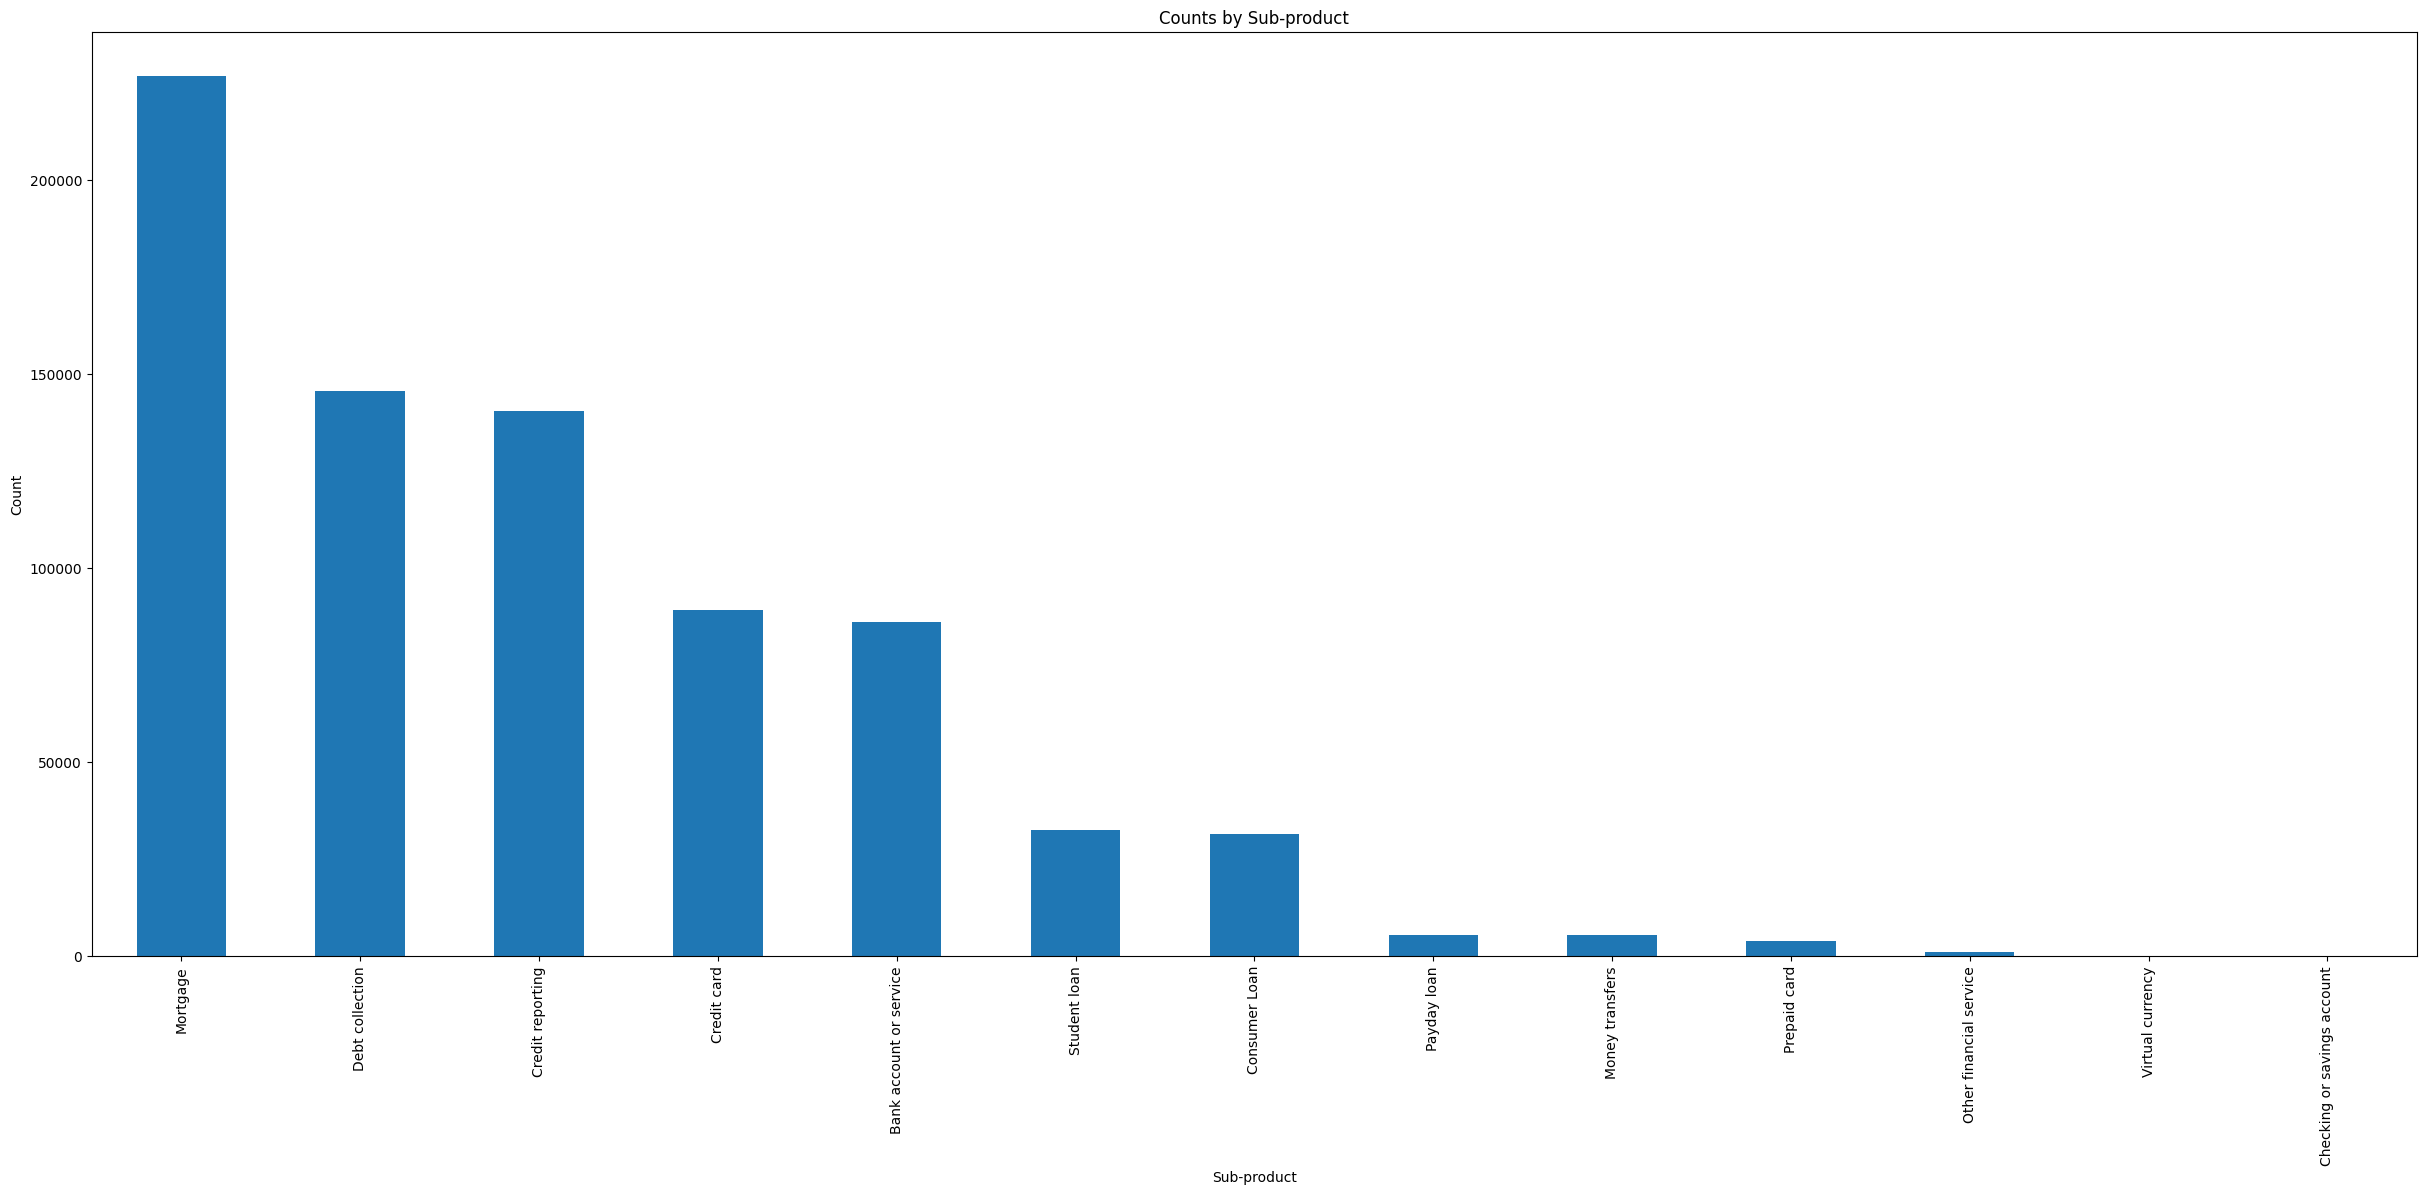

In [ ]:
#calculate the shares of the top three companies of the whole credit reporting dataset
print('Complaint disputed Sub-product accounts for {}% of the original dataset'.format((round(disputed['Product'].value_counts().head(3).sum()/ len(DATA)*100,1))))
#visualize the imbalance situation
plt.figure(figsize=(30, 12))
disputed['Product'].value_counts().head(20).plot(kind='bar')
plt.title('Counts by Sub-product')
plt.xlabel('Sub-product')
plt.ylabel('Count')
plt.show()



> We found that the first eleven sub-products account for about 99.99% of the not credit reporting part of the dataset.



In [21]:
#check the shares of the first 11 Products / all Products
print('Top 11 sub-products account for {}% of the not credit reporting'.format(round(disputed['Product'].value_counts().head(11).sum()/disputed['Product'].value_counts().sum()*100,3)))

Top 11 sub-products account for 99.997% of the not credit reporting




> As we decided to use the data points with disputed labels, we will use the disputed dataframe as our training set. The below analysis shows the null percent of each feature.



In [25]:
#check the null % for each feature
train_valid = disputed.drop(columns=['Tags', 'Complaint ID', 'Timely response?', 'Consumer consent provided?', 'Submitted via'])
train_valid.isnull().sum() / len(train_valid) * 100

Date received                    0.000000
Product                          0.000000
Sub-product                     30.605525
Issue                            0.000000
Sub-issue                       59.265342
Consumer complaint narrative    78.651358
Company public response         74.528931
Company                          0.000000
State                            0.735334
ZIP code                         0.501980
Date sent to company             0.000000
Company response to consumer     0.000000
Consumer disputed?               0.000000
dtype: float64



> The below analysis checks the null percentage of each feature of the credit reporting slices.



In [26]:
#check the null % for each feature
consumer_null.isnull().sum() / len(consumer_null) * 100

Date received                     0.000000
Product                           0.000000
Sub-product                       0.000000
Issue                             0.000000
Sub-issue                         0.952173
Consumer complaint narrative      0.000000
Company public response          36.169739
Company                           0.000000
State                             0.124862
ZIP code                          0.000000
Date sent to company              0.000000
Company response to consumer      0.000309
Consumer disputed?              100.000000
dtype: float64



> Based on our analyses of the two sets, we observed that the set has significant null values across multiple features. To ensure consistency between the training and test sets, we removed certain features that were deemed redundant or had high missing values. Specifically, we eliminated the 'sub-product' feature because 30% of its values were missing in the training set, whereas none were in the predict set. Instead, we have utilized the 'product' feature, which has complete data in both sets. Similarly, we discarded the 'sub-issue' and retained the 'issue' feature for consistency. We also removed rows in the training set that lacked narratives and omitted the 'company public response' feature due to its substantial missing data in both sets. Finally, considering both convey similar information, we retained the 'zip code' and discarded the 'state' feature. Below two analyses shows the results after our processing.



In [42]:
train_valid_narr = train_valid[train_valid['Consumer complaint narrative'].notnull()]
train_valid_narr_refine = train_valid_narr.drop(columns=['Sub-product','Sub-issue', 'Company public response', 'State'])
train_valid_narr_refine.isnull().sum() / len(train_valid_narr_refine) * 100

Date received                   0.0
Product                         0.0
Issue                           0.0
Consumer complaint narrative    0.0
Company                         0.0
ZIP code                        0.0
Date sent to company            0.0
Company response to consumer    0.0
Consumer disputed?              0.0
dtype: float64

In [43]:
#check the null % for each feature
consumer_null_refine = consumer_null.drop(columns=['Sub-product', 'Sub-issue', 'Company public response', 'State'])
consumer_null_refine = consumer_null_refine[consumer_null_refine['Company response to consumer'].notnull()]
consumer_null_refine.isnull().sum() / len(consumer_null_refine) * 100

Date received                     0.0
Product                           0.0
Issue                             0.0
Consumer complaint narrative      0.0
Company                           0.0
ZIP code                          0.0
Date sent to company              0.0
Company response to consumer      0.0
Consumer disputed?              100.0
dtype: float64



> Transform the date related features into datetime and the calculate the difference between Data received and Date set to company as the new feature "days". Moreover, we converted the labels of the consumer disputed into 0 and 1.



In [44]:
# convert date received and date sent to company to datetime format, and compute date sent - date received, store in column 'days' as int
train_valid_narr_refine['Date received'] = pd.to_datetime(train_valid_narr_refine['Date received'])
train_valid_narr_refine['Date sent to company'] = pd.to_datetime(train_valid_narr_refine['Date sent to company'])
train_valid_narr_refine['days'] = (train_valid_narr_refine['Date sent to company'] - train_valid_narr_refine['Date received']).dt.days

# drop Date received and Date sent to company columns
train_valid_narr_refine.drop(['Date received', 'Date sent to company'], axis=1, inplace=True)
train_valid_narr_refine.head(3)

,Product,Issue,Consumer complaint narrative,Company,ZIP code,Company response to consumer,Consumer disputed?,days
104757,Mortgage,"Loan modification,collection,foreclosure","I 'm currently working with Naca, in which the...",NATIONSTAR MORTGAGE LLC,010XX,Closed with explanation,No,4
109435,Consumer Loan,Managing the loan or lease,"A neighbor referred XXXX XXXX, Sears XXXX XXXX...","CITIBANK, N.A.",29212,Closed with explanation,No,0
109436,Mortgage,"Loan servicing, payments, escrow account","In XX/XX/XXXX I contacted Everbank, the servic...","EVERBANK, NATIONAL ASSOCIATION",060XX,Closed with explanation,No,6


In [45]:
# encode disputed column to 0 and 1
train_valid_narr_refine['Consumer disputed?'] = train_valid_narr_refine['Consumer disputed?'].map({'No': 0, 'Yes': 1})
train_valid_narr_refine.head(3)

,Product,Issue,Consumer complaint narrative,Company,ZIP code,Company response to consumer,Consumer disputed?,days
104757,Mortgage,"Loan modification,collection,foreclosure","I 'm currently working with Naca, in which the...",NATIONSTAR MORTGAGE LLC,010XX,Closed with explanation,0,4
109435,Consumer Loan,Managing the loan or lease,"A neighbor referred XXXX XXXX, Sears XXXX XXXX...","CITIBANK, N.A.",29212,Closed with explanation,0,0
109436,Mortgage,"Loan servicing, payments, escrow account","In XX/XX/XXXX I contacted Everbank, the servic...","EVERBANK, NATIONAL ASSOCIATION",060XX,Closed with explanation,0,6


In [46]:
# convert date received and date sent to company to datetime format, and compute date sent - date received, store in column 'days' as int
consumer_null_refine['Date received'] = pd.to_datetime(consumer_null_refine['Date received'])
consumer_null_refine['Date sent to company'] = pd.to_datetime(consumer_null_refine['Date sent to company'])
consumer_null_refine['days'] = (consumer_null_refine['Date sent to company'] - consumer_null_refine['Date received']).dt.days

# drop Date received and Date sent to company columns
consumer_null_refine.drop(['Date received', 'Date sent to company'], axis=1, inplace=True)
consumer_null_refine.head(3)

,Product,Issue,Consumer complaint narrative,Company,ZIP code,Company response to consumer,Consumer disputed?,days
6,"Credit reporting, credit repair services, or o...",Problem with a credit reporting company's inve...,I submitted a letter to the XXXX Credit Bureau...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",32221,Closed with non-monetary relief,NaN,0
37,"Credit reporting, credit repair services, or o...",Improper use of your report,In accordance with the Fair Credit Reporting a...,Experian Information Solutions Inc.,35173,Closed with non-monetary relief,NaN,0
40,"Credit reporting, credit repair services, or o...",Incorrect information on your report,XX/XX/XXXX ] [ XXXX XXXX XXXX ] [ XXXX XXXX XX...,Experian Information Solutions Inc.,49022,Closed with explanation,NaN,0




*   Training Set before Vectorization



In [49]:
train_df_before_vector = train_valid_narr_refine.copy()
print('Training set: {} rows'.format(len(train_df_before_vector)))

Training set: 164034 rows




*   Prediction set before Vectorization



In [57]:
predict_df_before_vector = consumer_null_refine.copy()
print('Test set: {} rows'.format(len(predict_df_before_vector)))

Test set: 646309 rows


**Step 4: Word Embedding and Feature Vectorization**


In [38]:
# import word2vec model (this take a while to load)
word2vec = KeyedVectors.load_word2vec_format(file_path_03, binary=True)

In [39]:
# helper func: preprocess the narrative column

def preprocess_narrative(text):

    # Lowercase
    text = text.lower()

    # Remove XXXX like pattern
    text = re.sub(r'x{2,}', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing spaces
    text = text.strip()

    return text



> Approach: Mixture of categorical columns and TFIDF w2v matrix



In [58]:
# preprocess narrative column and store in narrative_processed column
train_df_before_vector['narrative_processed'] = train_df_before_vector['Consumer complaint narrative'].progress_apply(preprocess_narrative)
predict_df_before_vector['narrative_processed'] = predict_df_before_vector['Consumer complaint narrative'].progress_apply(preprocess_narrative)

100%|██████████| 646309/646309 [00:55<00:00, 11661.49it/s]


In [54]:
# instantiate tfidf

tfidf = TfidfVectorizer()

# fit and transform tfidf vectorizer on narrative_processed column
tfidf.fit(train_df_before_vector.narrative_processed)

# get tfidf feature names
tfidf_features = tfidf.get_feature_names_out()

# get tfidf weights
tfidf_weights = tfidf.idf_


In [55]:
# define a function get mean word2vec vector for a narrative

def get_mean_word2vec(narrative):

    # initialize vector
    vector = np.zeros(300)

    # get all words in narrative
    words = narrative.split()
    num_words = len(words)

    if num_words == 0:  # edge case: empty narrative
        return vector

    # calculate word vectors using list comprehension
    word_vectors = [word2vec[word] for word in words if word in word2vec]

    if word_vectors:
        vector = np.mean(word_vectors, axis=0)

    return vector


# define a function get mean tfidf weighted word2vec vector for a narrative
def get_mean_tfidf_weighted_word2vec(narrative):

    # initialize vector
    vector = np.zeros(300)

    # get all words in narrative
    words = narrative.split()
    num_words = len(words)

    if num_words == 0:  # edge case: empty narrative
        return vector

    # pre-calculate word-to-index mapping for tfidf_features for O(1) lookup
    word_to_index = {word: idx for idx, word in enumerate(tfidf_features)}

    # calculate word vectors using list comprehension
    word_vectors = [
        word2vec[word] * tfidf_weights[word_to_index[word]]
        for word in words if word in word2vec and word in word_to_index
    ]

    if word_vectors:
        vector = np.sum(word_vectors, axis=0) / num_words

    return vector

In [56]:
# compute mean tfidf weighted word2vec vector for each narrative (take a while)
train_df_before_vector['narrative_tw'] = train_df_before_vector['narrative_processed'].progress_apply(get_mean_tfidf_weighted_word2vec)
predict_df_before_vector['narrative_tw'] = predict_df_before_vector['narrative_processed'].progress_apply(get_mean_tfidf_weighted_word2vec)
# convert train_df_before_vector['narrative_tw'] to numpy array tw_array
tw_array_train = np.array(train_df_before_vector.narrative_tw.tolist())
# convert test_df_before_vector['narrative_tw'] to numpy array tw_array
tw_array_predict = np.array(predict_df_before_vector.narrative_tw.tolist())
# print shape of tw_array
print('Train: {}'.format(tw_array_train.shape))
print('Test: {}'.format(tw_array_predict.shape))

 11%|█         | 17777/164034 [06:55<56:56, 42.81it/s]


KeyboardInterrupt: ignored

In [ ]:
# copy target column to y
y = train_df_before_vector['Consumer disputed?'].copy()

In [ ]:
train_df_before_vector.columns

Index(['Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'Tags', 'Company response to consumer', 'Consumer disputed?',
       'days', 'narrative_processed', 'narrative_tw'],
      dtype='object')

In [ ]:
# drop Consumer complaint narrative, narrative_processed, Consumer disputed? columns
train_df_before_vector.drop(['Consumer complaint narrative', 'narrative_processed', 'narrative_tw', 'Consumer disputed?'], axis=1, inplace=True)
predict_df_before_vector.drop(['Consumer complaint narrative', 'narrative_processed', 'narrative_tw', 'Consumer disputed?'], axis=1, inplace=True)

In [ ]:
train_df_before_vector.nunique()

Product                           12
Sub-product                       47
Issue                             91
Sub-issue                         58
Company public response           11
Company                         3148
State                             63
Tags                               4
Company response to consumer       5
days                             269
dtype: int64

In [ ]:
predict_df_before_vector.nunique()

In [ ]:
# concatenate tw_array_train with train_df_before_vector
X = np.concatenate((tw_array_train, train_df_before_vector), axis=1)
X_predict = np.concatenate((tw_array_predict, predict_df_before_vector), axis=1)
# check shape of X
print('X.shape: {}'.format(X.shape))
print('X_predict.shape: {}'.format(X_predict.shape))

(164034, 3740)

In [ ]:
# smoote to oversample minority class
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# print shape of X_smote, y_smote
print(X_smote.shape, y_smote.shape)

(256454, 3740) (256454,)


**Consider Boostrapping and Semi-supervising**


# Run the models and evaluations

In [ ]:
# train test split, 20% test, random_state=42, stratify=y_smote
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, stratify=y_smote, random_state=42, test_size=0.2)

# print shape
print(X_smote_train.shape, X_smote_test.shape, y_smote_train.shape, y_smote_test.shape)

(205163, 3740) (51291, 3740) (205163,) (51291,)


In [ ]:
# train with logistic regression, wrap in a function

def train_lr(X_train, y_train, X_test, y_test):

    # instantiate logistic regression model
    lr = LogisticRegression(max_iter=1000, random_state=42).fit(X_train, y_train)

    # predict on test set
    y_pred = lr.predict(X_test)

    # print f1 score
    print(f"f1 score: {f1_score(y_test, y_pred)}")

    return lr


# train naive bayes

def train_naive_bayes(X_train, y_train, X_test, y_test):

    # instantiate naive bayes model
    nb = MultinomialNB()

    # fit model
    nb.fit(X_train, y_train)

    # predict on test set
    y_pred = nb.predict(X_test)

    # print f1 score
    print(f"f1 score: {f1_score(y_test, y_pred)}")

    return nb


# train lightgbm

def train_lgbm(X_train, y_train, X_test, y_test):

    # instantiate lightgbm model
    lgbm = LGBMClassifier(random_state=42).fit(X_train, y_train)

    # predict on test set
    y_pred = lgbm.predict(X_test)

    # print f1 score
    print(f"f1 score: {f1_score(y_test, y_pred)}")

    return lgbm


# train with xgboost

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="Starting in XGBoost")

def train_xgb(X_train, y_train, X_test, y_test):

    # instantiate xgboost model
    xgb = XGBClassifier(random_state=42, n_jobs=-1)

    # fit model
    xgb.fit(X_train, y_train)

    # predict on test set
    y_pred = xgb.predict(X_test)

    # print f1 score
    print(f"f1 score: {f1_score(y_test, y_pred)}")

    return xgb


# catboost in a function

def train_catboost(X_train, y_train, X_test, y_test):

    # instantiate catboost model
    catboost = CatBoostClassifier(random_state=42)

    # fit model
    catboost.fit(X_train, y_train)

    # predict on test set
    y_pred = catboost.predict(X_test)

    # print accuracy score
    print(f"accuracy score: {accuracy_score(y_test, y_pred)}")

    # print f1 score
    print(f"f1 score: {f1_score(y_test, y_pred)}")

    return catboost


# train ann

def train_ann_tw_onehot(X_train, y_train, X_test, y_test):

    # instantiate ann model
    ann = Sequential()

    # add input layer
    ann.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

    # add hidden layers
    ann.add(Dense(64, activation='relu'))
    ann.add(Dense(32, activation='relu'))
    ann.add(Dense(16, activation='relu'))

    # add output layer
    ann.add(Dense(1, activation='sigmoid'))

    # compile model
    ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # fit model
    ann.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    # predict on test set
    y_pred = ann.predict(X_test)

    # print f1 score
    print(f"f1 score: {f1_score(y_test, y_pred.round())}")

    return ann


In [ ]:
# train with logistic regression

model_lr = train_lr(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

f1 score: 0.661993306061733


In [ ]:
# train with naive bayes, scale values as nb not working with negative

min_max_scaler = MinMaxScaler()

model_nb = train_naive_bayes(min_max_scaler.fit_transform(X_smote_train), y_smote_train, min_max_scaler.transform(X_smote_test), y_smote_test)

f1 score: 0.6275373134328358


In [ ]:
# train lightgbm

model_lgbm = train_lgbm(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

[LightGBM] [Info] Number of positive: 102582, number of negative: 102581
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.170707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138687
[LightGBM] [Info] Number of data points in the train set: 205163, number of used features: 1395
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000010
[LightGBM] [Info] Start training from score 0.000010
f1 score: 0.8021170370052925


In [ ]:
# train catboost

model_catboost = train_catboost(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

Learning rate set to 0.100046
0:	learn: 0.6778634	total: 139ms	remaining: 2m 19s
1:	learn: 0.6672408	total: 224ms	remaining: 1m 51s
2:	learn: 0.6608011	total: 310ms	remaining: 1m 43s
3:	learn: 0.6471036	total: 396ms	remaining: 1m 38s
4:	learn: 0.6419977	total: 487ms	remaining: 1m 36s
5:	learn: 0.6374393	total: 569ms	remaining: 1m 34s
6:	learn: 0.6336227	total: 653ms	remaining: 1m 32s
7:	learn: 0.6178641	total: 735ms	remaining: 1m 31s
8:	learn: 0.6149668	total: 814ms	remaining: 1m 29s
9:	learn: 0.6082395	total: 899ms	remaining: 1m 28s
10:	learn: 0.6056475	total: 983ms	remaining: 1m 28s
11:	learn: 0.5951178	total: 1.06s	remaining: 1m 27s
12:	learn: 0.5926962	total: 1.15s	remaining: 1m 27s
13:	learn: 0.5868123	total: 1.24s	remaining: 1m 27s
14:	learn: 0.5848577	total: 1.32s	remaining: 1m 26s
15:	learn: 0.5829106	total: 1.4s	remaining: 1m 25s
16:	learn: 0.5812108	total: 1.47s	remaining: 1m 25s
17:	learn: 0.5772455	total: 1.55s	remaining: 1m 24s
18:	learn: 0.5755182	total: 1.63s	remaining: 

In [ ]:
# train xgboost

model_xgb = train_xgb(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

f1 score: 0.8097169377430279


In [ ]:
# train ann

model_ann = train_ann_tw_onehot(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

Epoch 1/10
6412/6412 [==============================] - 32s 4ms/step - loss: 0.6101 - accuracy: 0.6651 - val_loss: 0.5798 - val_accuracy: 0.6963
Epoch 2/10
6412/6412 [==============================] - 23s 4ms/step - loss: 0.5475 - accuracy: 0.7233 - val_loss: 0.5414 - val_accuracy: 0.7289
Epoch 3/10
6412/6412 [==============================] - 23s 4ms/step - loss: 0.5018 - accuracy: 0.7560 - val_loss: 0.5318 - val_accuracy: 0.7411
Epoch 4/10
6412/6412 [==============================] - 23s 4ms/step - loss: 0.4635 - accuracy: 0.7802 - val_loss: 0.5175 - val_accuracy: 0.7467
Epoch 5/10
6412/6412 [==============================] - 23s 4ms/step - loss: 0.4329 - accuracy: 0.7992 - val_loss: 0.5023 - val_accuracy: 0.7615
Epoch 6/10
6412/6412 [==============================] - 24s 4ms/step - loss: 0.4073 - accuracy: 0.8129 - val_loss: 0.4851 - val_accuracy: 0.7719
Epoch 7/10
6412/6412 [==============================] - 23s 4ms/step - loss: 0.3851 - accuracy: 0.8263 - val_loss: 0.4826 - val_ac